In [1]:
import tensorflow as tf
import os

def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}_20211019.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

model = tf.saved_model.load(download_model('metrabs_mob3l_y4t')) # or metrabs_eff2l_y4 for the big model
! wget -q https://raw.githubusercontent.com/isarandi/metrabs/master/img/test_image_3dpw.jpg


'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [27]:
import cv2
image = cv2.imread('C:/Users/Leeyourack/jookyoung/image/1.test_image/peo3.jpg') 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ROI_image = cv2.imread('C:/Users/Leeyourack/jookyoung/image/0.ROI_image/pre_image_final.jpg')
ROI_image = cv2.cvtColor(ROI_image, cv2.COLOR_BGR2RGB)


In [28]:
pred = model.detect_poses(image, skeleton='smpl_24')

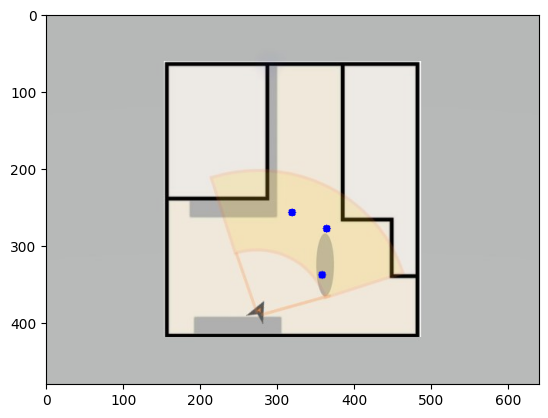

In [44]:
foot_xy = pred['poses2d'].numpy()[:,23]
foot_xy
import numpy as np
M1=np.array([[ 1.45097602e-01, -5.41867598e-01,  3.12288400e+02],
       [ 2.15106760e-01,  5.04711845e-01, -1.13262800e+02],
       [ 3.66469646e-05, -1.34106205e-03,  1.00000000e+00]])
from matplotlib import pyplot as plt
for i, xy in enumerate(foot_xy):
    trans_foot = M1@(xy[0], xy[1], 1)
    trans_foot = trans_foot/trans_foot[2]
    trans_x = trans_foot[0]
    trans_y = trans_foot[1]
    
    mapping_image= cv2.circle(ROI_image,(int(trans_x),int(trans_y)),5,(0,0,255),-1)
    
plt.imshow(mapping_image)

boxes: [left, top, width, height, confidence] for each detection box. Shape is [num_detections, 5].

poses2d: Like poses3d, except in 2D pixel coordinates (addressing the input image's pixel space) so it has shape [num_detections, num_joints, 2] if average_aug is True, else [num_detections, num_aug, num_joints, 2].

poses3d: The 3D poses corresponding to the detected people. Each pose is shaped [num_joints, 3] and is given in the 3D world coordinate system in millimeters (or in the camera coordinate frame, if extrinsic_matrix is not specified). The number of joints depends on the selected skeleton as input argument. Shape is [num_detections, num_joints, 3] if average_aug is True, else [num_detections, num_aug, num_joints, 3].

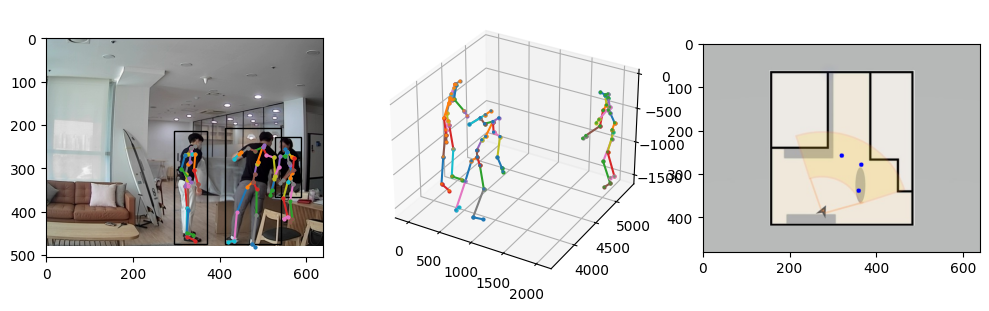

In [43]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

def visualize(im, detections, poses3d, poses2d, edges):
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 3, 1)
    image_ax.imshow(image)
    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 3, 2, projection='3d')
    '''pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500) 
    pose_ax.set_zlim3d(-500, 1500)
    pose_ax.set_ylim3d(0, 3000)'''


    #------------------------------------------------------------------------------------------------------
    ##2Dmapping

    foot_xy = pred['poses2d'].numpy()[:,23]
    
    for i, xy in enumerate(foot_xy):
        trans_foot = M1@(xy[0], xy[1], 1)
        trans_foot = trans_foot/trans_foot[2]
        trans_x = trans_foot[0]
        trans_y = trans_foot[1]
        
        mapping_image= cv2.circle(ROI_image,(int(trans_x),int(trans_y)),5,(0,0,255),-1)

    foot = fig.add_subplot(1, 3, 3)
    foot.imshow(mapping_image)
    
    #------------------------------------------------------------------------------------------------------
    
    
    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # matplot은 z를 수직축으로 잡는다. 하지만 우리의 pose는 y를 수직축으로 가진다.
    # Therefore, we do a 90° rotation around the X axis:
    # x축으로 90도 회전해야한다.
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, poses2d):
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2) #점찍기
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2) 
        pose_ax.scatter(*pose3d.T, s=2)

    fig.tight_layout()
    plt.show()

visualize(
    image, 
    pred['boxes'].numpy(),
    pred['poses3d'].numpy(),
    pred['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy())

In [51]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

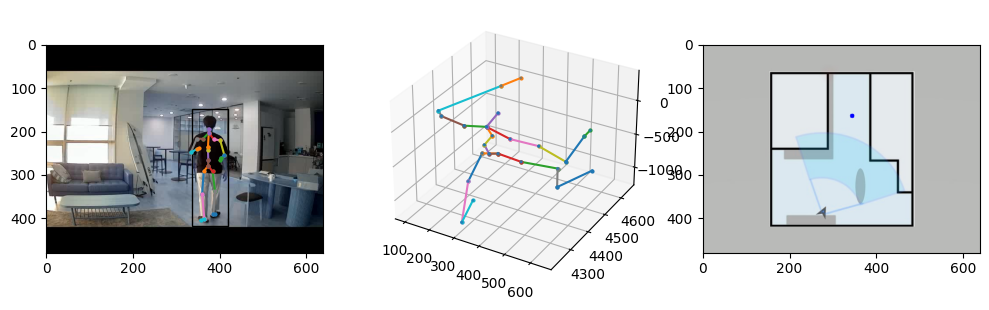

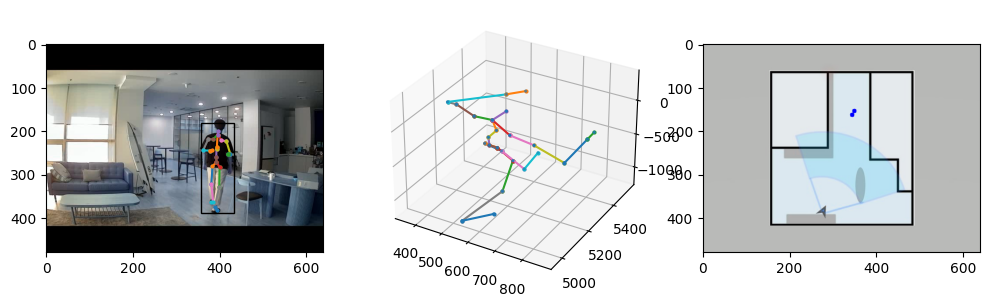

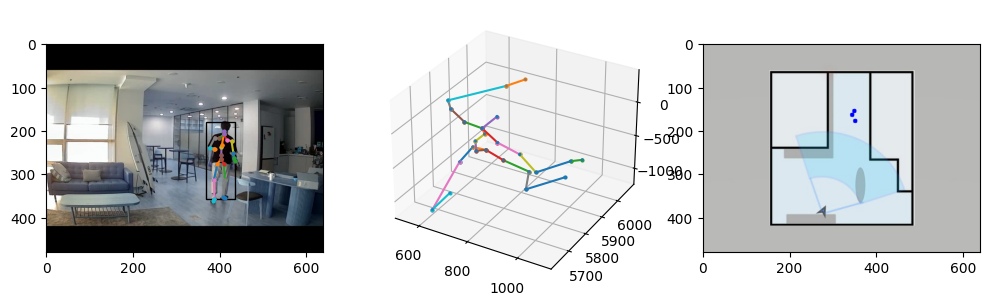

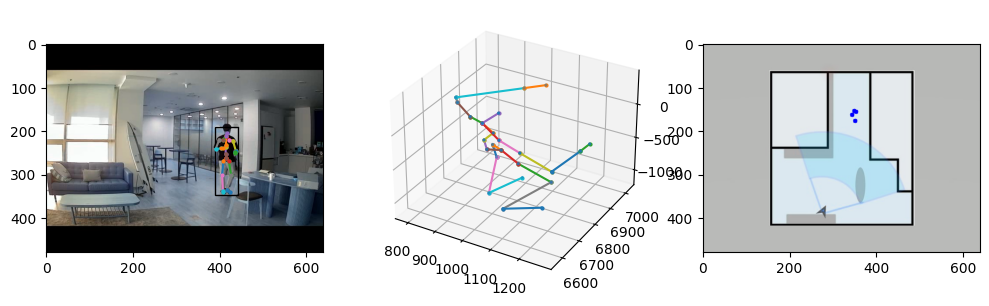

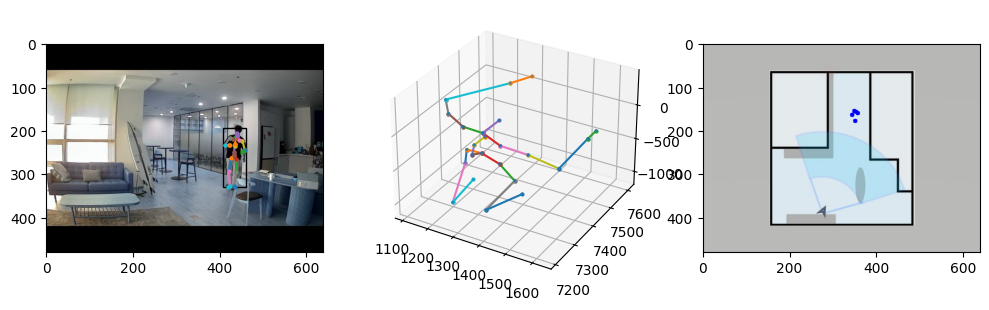

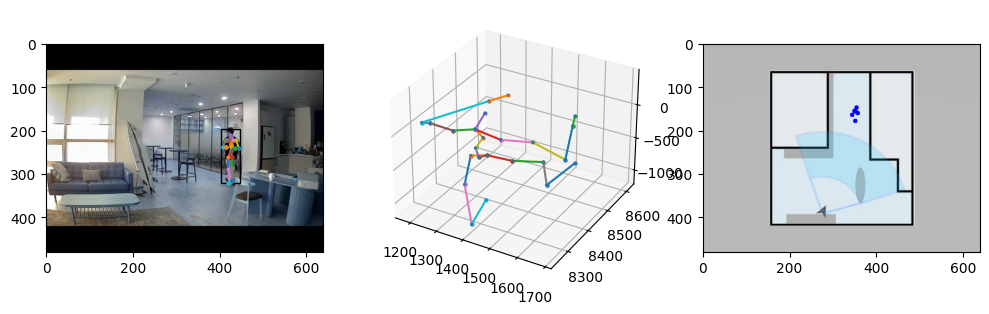

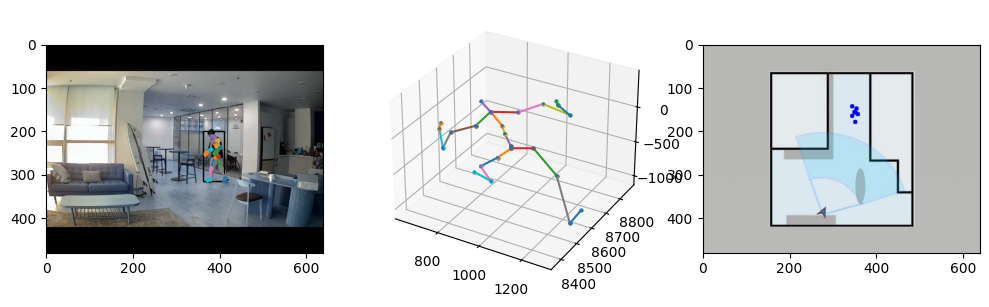

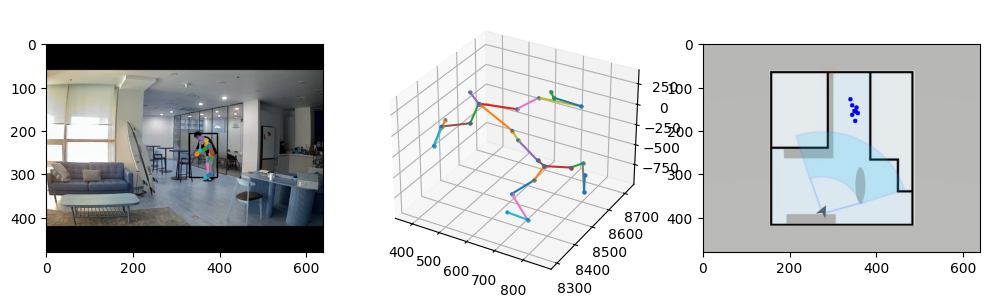

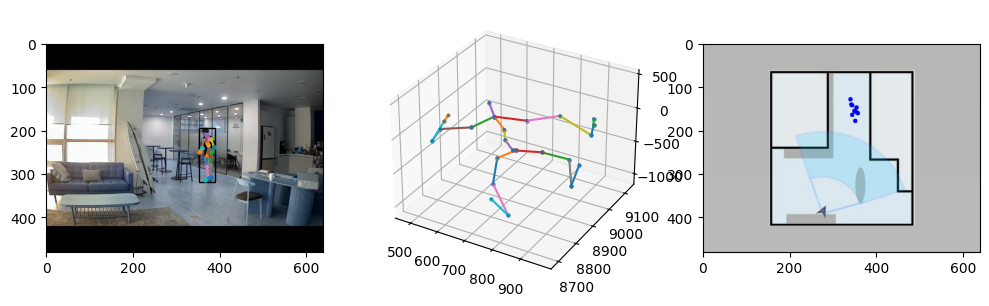

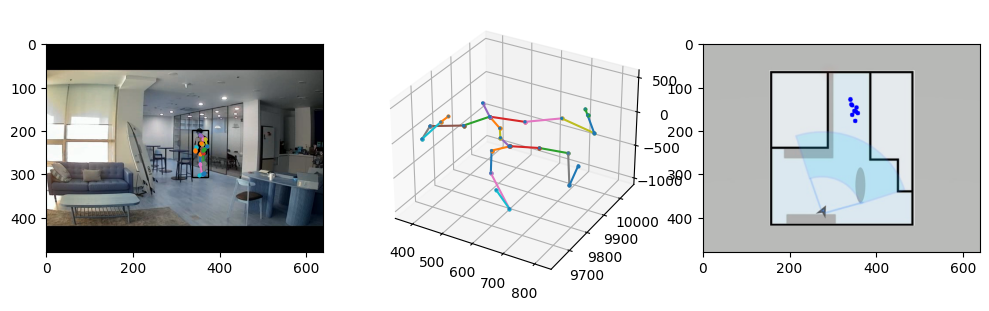

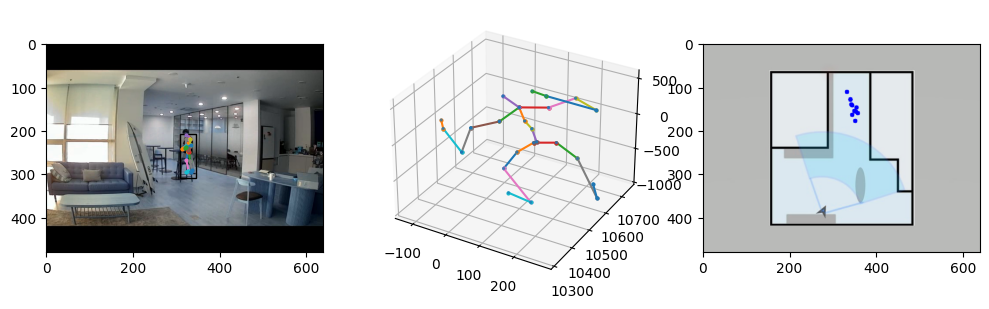

UnboundLocalError: local variable 'mapping_image' referenced before assignment

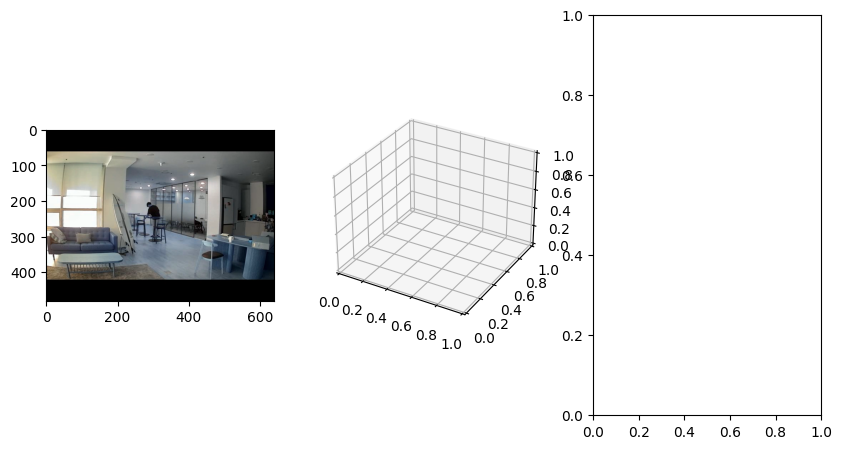

In [54]:
cap = cv2.VideoCapture('C:/Users/Leeyourack/jookyoung/video/1.test_video/raw.avi')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('C:/Users/Leeyourack/jookyoung/video/2.detect_video/detect1.avi', fourcc, 10, (int(width),int(height)))
ROI_image = cv2.imread('C:/Users/Leeyourack/jookyoung/image/0.ROI_image/pre_image_final.jpg')
i=0

while cap.isOpened():
    ret, frame = cap.read()

    pred = model.detect_poses(frame, skeleton='smpl_24')
    def visualize(im, detections, poses3d, poses2d, edges):
        fig = plt.figure(figsize=(10, 5.2))
        image_ax = fig.add_subplot(1, 3, 1)
        image_ax.imshow(frame)
        for x, y, w, h in detections[:, :4]:
            image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

        pose_ax = fig.add_subplot(1, 3, 2, projection='3d')
        '''pose_ax.view_init(5, -85)
        pose_ax.set_xlim3d(-1500, 1500) 
        pose_ax.set_zlim3d(-500, 1500)
        pose_ax.set_ylim3d(0, 3000)'''


        #------------------------------------------------------------------------------------------------------
        ##2Dmapping

        foot_xy = pred['poses2d'].numpy()[:,23]
        
        for i, xy in enumerate(foot_xy):
            trans_foot = M1@(xy[0], xy[1], 1)
            trans_foot = trans_foot/trans_foot[2]
            trans_x = trans_foot[0]
            trans_y = trans_foot[1]
            
            mapping_image= cv2.circle(ROI_image,(int(trans_x),int(trans_y)),5,(0,0,255),-1)

        foot = fig.add_subplot(1, 3, 3)
        foot.imshow(mapping_image)
        
        #------------------------------------------------------------------------------------------------------
        
        
        # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
        # matplot은 z를 수직축으로 잡는다. 하지만 우리의 pose는 y를 수직축으로 가진다.
        # Therefore, we do a 90° rotation around the X axis:
        # x축으로 90도 회전해야한다.
        poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
        for pose3d, pose2d in zip(poses3d, poses2d):
            for i_start, i_end in edges:
                image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2) #점찍기
                pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
            image_ax.scatter(*pose2d.T, s=2) 
            pose_ax.scatter(*pose3d.T, s=2)

        fig.tight_layout()
        plt.show()

    visualize(
        frame, 
        pred['boxes'].numpy(),
        pred['poses3d'].numpy(),
        pred['poses2d'].numpy(),
        model.per_skeleton_joint_edges['smpl_24'].numpy())
  

    

    i = i + 1
    cv2.imshow('test',frame)
    out.write(frame)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows    

